<a href="https://colab.research.google.com/github/PranjalSahu/OAI_analysis_2/blob/pranjal2/notebooks/FullDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages
!pip install vtk
!pip install itkwidgets
!pip install itk
!pip install icon-registration==0.2.1
!git clone -b pranjal2 https://github.com/PranjalSahu/OAI_analysis_2.git

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import itk
import vtk
from vtk.util import numpy_support as ns
from itkwidgets import view
from skimage import measure
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import copy
import icon_registration.itk_wrapper as itk_wrapper
import icon_registration.pretrained_models as pretrained_models
import matplotlib.pyplot as plt

# Remove this once the pip package is available
import sys
sys.path.append("./OAI_analysis_2/oai_analysis_2/")
import mesh_processing as mp

# To enable running the itkwidgets window on colab
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# Download the relevant files such as input image, atlas image, segmented TC and FC maps

!girder-client --api-url https://data.kitware.com/api/v1 localsync 621a5d784acac99f426c143b OAIData

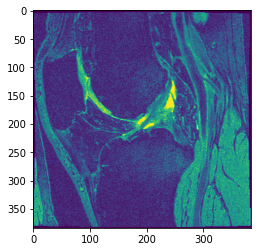

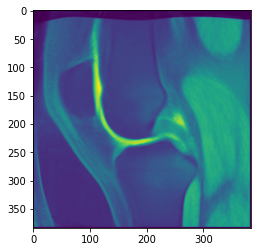

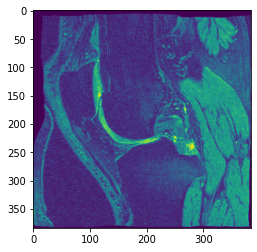

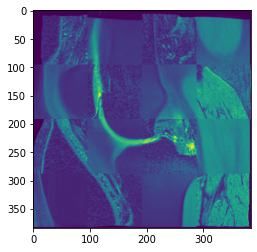

In [ ]:
# Register the Atlas and the given image

model = pretrained_models.OAI_knees_registration_model()

image_A = itk.imread("./OAIData/image_preprocessed.nii.gz", itk.D)
image_B = itk.imread("./OAIData/atlas_image.nii.gz", itk.D)


# Register the images
phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)

interpolator = itk.LinearInterpolateImageFunction.New(image_A)
warped_image_A = itk.resample_image_filter(image_A, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)


# Plot the images to check the alignment
checker_board = itk.checker_board_image_filter(warped_image_A, image_B)

plt.imshow(image_A[80])
plt.show()
plt.imshow(image_B[80])
plt.show()

plt.imshow(warped_image_A[80])
plt.show()

plt.imshow(itk.checker_board_image_filter(warped_image_A, image_B)[80])
plt.show()

In [ ]:
# For deforming the FC and TC probability images using the transform obtained after registration

fc_prob_file = './OAIData/FC_probmap.nii.gz'
tc_prob_file = './OAIData/TC_probmap.nii.gz'

FC_prob = itk.imread(fc_prob_file)
TC_prob = itk.imread(tc_prob_file)

warped_image_FC = itk.resample_image_filter(FC_prob, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)


warped_image_TC = itk.resample_image_filter(TC_prob, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)

print(warped_image_FC.shape)
print(warped_image_TC.shape)

(160, 384, 384)
(160, 384, 384)


In [ ]:
# Get the thickness map for the meshes

distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')

In [ ]:
# Get inner and outer meshes for the TC and FC atlas meshes

prob_fc_atlas = itk.imread('./OAIData/atlas_fc.nii.gz')
mesh_fc_atlas = mp.get_mesh(prob_fc_atlas)
inner_mesh_fc_atlas, outer_mesh_fc_atlas = mp.split_mesh(mesh_fc_atlas, mesh_type='FC')

prob_tc_atlas = itk.imread('./OAIData/atlas_tc.nii.gz')
mesh_tc_atlas = mp.get_mesh(prob_tc_atlas)
inner_mesh_tc_atlas, outer_mesh_tc_atlas = mp.split_mesh(mesh_tc_atlas, mesh_type='TC')

In [ ]:
# For mapping the thickness to the atlas mesh

mapped_mesh_fc = mp.map_attributes(distance_inner_FC, inner_mesh_fc_atlas)
mapped_mesh_tc = mp.map_attributes(distance_inner_TC, inner_mesh_tc_atlas)

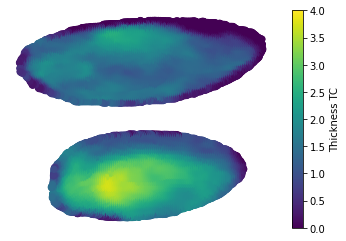

In [ ]:
# Plot the 2D Thickness projection for TC

mesh_type = 'TC'
x, y, t = mp.project_thickness(mapped_mesh_tc, mesh_type=mesh_type)

s = plt.scatter(x, y, c=t, vmin=0, vmax=4)
cb = plt.colorbar(s)
cb.set_label('Thickness '+mesh_type)
plt.axis('off')
plt.draw()
plt.savefig('thickness_'+mesh_type+'.png')
plt.show()

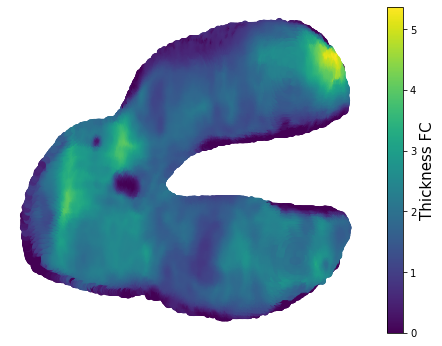

In [ ]:
# Plot the 2D Thickness projection for FC

mesh_type = 'FC'
x, y, t = mp.project_thickness(mapped_mesh_fc, mesh_type=mesh_type)

plt.figure(figsize=(8, 6))

s = plt.scatter(x, y, c=t)

cb = plt.colorbar(s)
cb.set_label('Thickness '+mesh_type, size=15)
plt.axis('off')
plt.draw()
plt.savefig('thickness_'+mesh_type+'.png')
plt.show()

In [ ]:
# Visualize the thickness map

view(geometries=[distance_inner_TC])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# Visualize the thickness map

view(geometries=[distance_inner_FC])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…